In [1]:
import pde
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use("ggplot")
plt.rcParams.update({'font.size': 12})

# funkce řešení úlohy

def fksolve(domain_size=100.,
           grid_size = 500,
           max_time = 9,   # 10 steps, as count starting 0
           dt = 0.001,
           tracker_int = 0.05,
           iv_size = 100,
           iv_func = lambda x, y: 1,
           slice_num = 10,
           ylim = 1.1,
           u_level = 0.2):   # u value to approximate the speed at

    fig = plt.figure(figsize=(20,18))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    # grid 
    grid = pde.CartesianGrid([[0, domain_size]]*2, grid_size)
    
    # axisymmetric initial values
    X = np.linspace(-1.,1.,iv_size)
    Y = np.linspace(-1.,1.,iv_size)
    Z = np.zeros((iv_size,iv_size))
    for i in range(0,iv_size): 
        for j in range(0,iv_size):
            if X[i]**2+Y[j]**2<1:
                Z[i,j] = iv_func(X[i],Y[j])
    x0 = np.zeros(grid.shape)
    lo = int((grid_size - iv_size)/2)
    hi = lo+iv_size
    x0[lo:hi, lo:hi] = Z

    state = pde.ScalarField(grid,x0) #.smooth()
    state.plot(cmap='Blues', clim=(0,1), ax=ax1, title='Počáteční podmínka')
    
    # solve the problem
    eq = pde.PDE(
        {"u": "laplace(u) + u*(1-u)"},
    )
    storage = pde.MemoryStorage()
    tracker = ['progress', storage.tracker(interval=tracker_int)] 
    result = eq.solve(state, t_range=max_time, dt=dt, tracker=tracker)
    
    
    # plot results

    
    t_size = len(storage.data)-1
    ts = np.linspace(0, t_size, slice_num, dtype=np.int32)
    
    X = np.linspace(0, domain_size, grid_size)#x_size)
    
    cmap = plt.get_cmap('Blues')
    colors = cmap(np.linspace(.4, 1.0, slice_num))    
    for t, color in zip(ts, colors):
        ax3.plot(X,storage.data[t][int(grid_size/2)], color=color, label='t={:.2f}'.format(t*tracker_int))

    ax3.set_xlabel('y')
    ax3.set_ylabel('u({:.2f},y,t)'.format(domain_size/2))
    ax3.set_title('Řezy řešení u(x,y,t) v x={:.2f}'.format(domain_size/2))
    ax3.set_xlim([0,domain_size])
    ax3.set_ylim([0,ylim])   
    ax3.legend()
    
    result.plot(cmap='Blues', clim=(0,1), ax=ax2, title='Řešení u(x,y,t) v čase t={}'.format(max_time))
    
    # c(r) speed
    ts = np.linspace(0, len(storage.data)-1, slice_num)
    ts = ts.astype(int)
    t_size = len(ts)
    rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])
    
    half_grid_size = int(grid_size/2)

    r_t = np.zeros(t_size)
    
    for t in range(t_size):
        r_data = storage.data[ts[t]][half_grid_size]
        #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
        #r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
        
        rs_inx = np.argwhere(r_data>=u_level)
        r_t[t] = rs[rs_inx[-1]] + (rs[rs_inx[-1]+1] - rs[rs_inx[-1]]) * ((u_level - r_data[rs_inx[-1]+1])/(r_data[rs_inx[-1]] - r_data[rs_inx[-1]+1])) 
        
    x = np.linspace(0, max_time, len(r_t))
    #z = np.polyfit(x,r_t,5)
    #p = np.poly1d(z)
    #p = p.deriv()
    
    #ax3.plot(x, p(x), color='#0000AA', linewidth=2)
    #ax3.set_xlabel('t')
    #ax3.set_ylabel('c(x,y,t)')
    #ax3.set_title('Aproximace rychlosti pravé části vlny v u(x,y,t)={}'.format(u_level))
    
    ax4.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
    ax4.set_xlabel('t')
    ax4.set_ylabel('c(x,y,t)')
    ax4.set_title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

    plt.show()

    return result, storage, grid

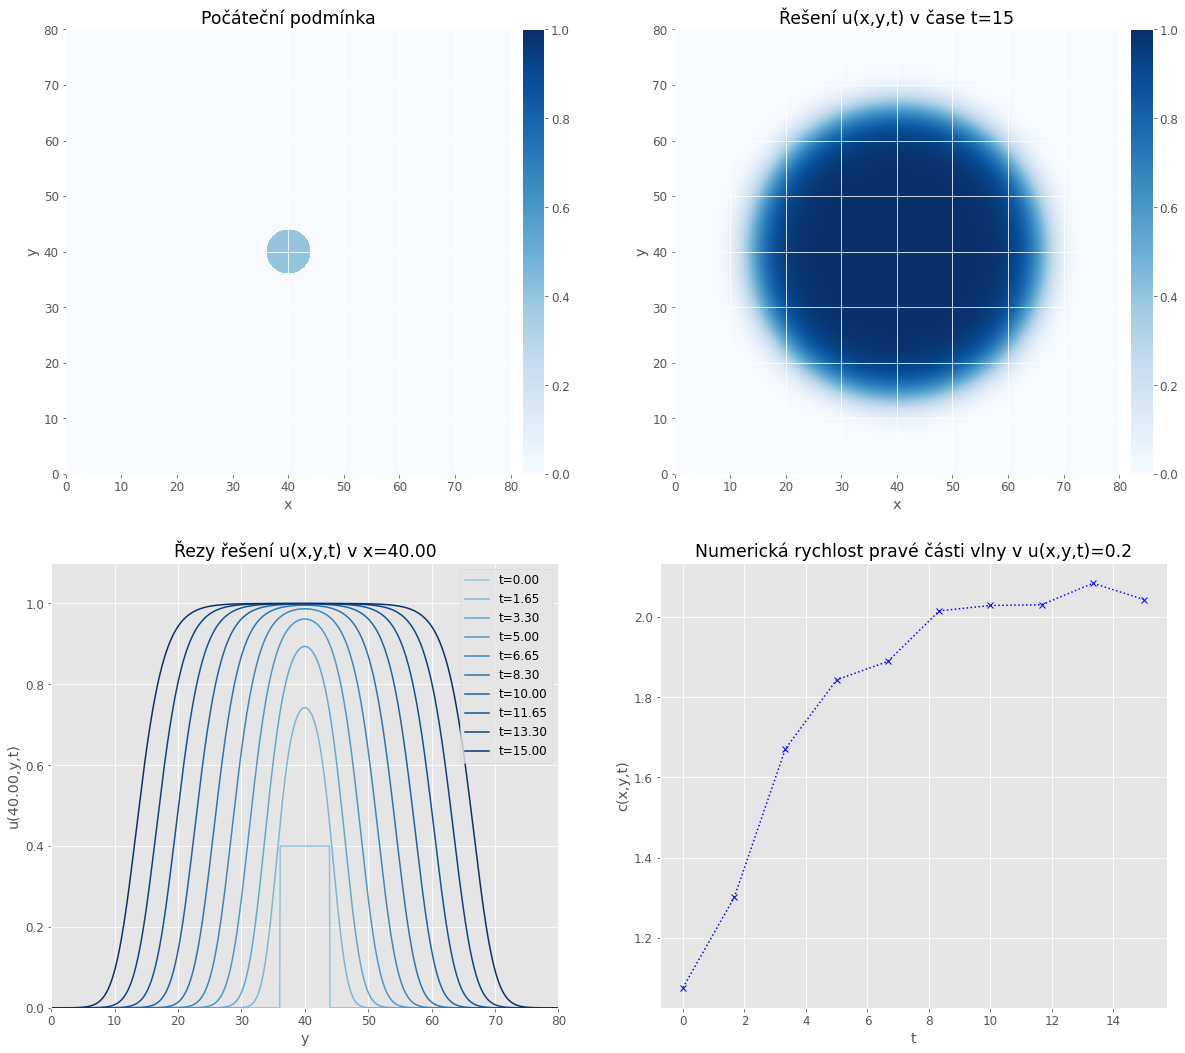

In [17]:
result, storage, grid = fksolve(iv_func = lambda x,y: .4,
                 max_time = 15,
                 domain_size = 80,
                 grid_size = 1000
               )

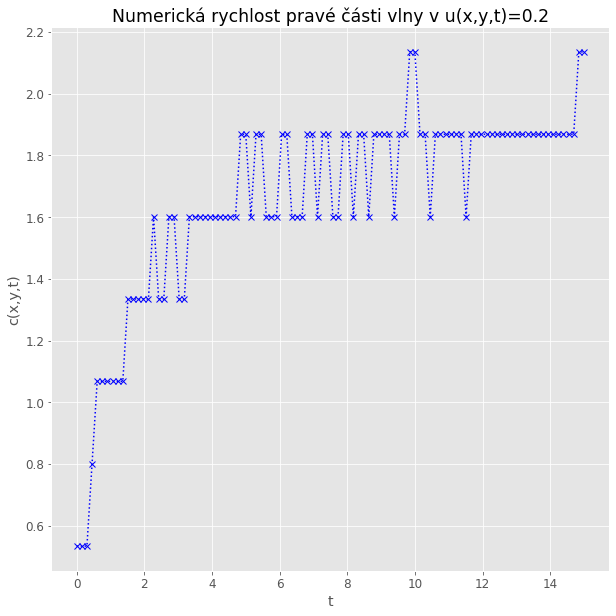

In [21]:
# c(r) speed
slice_num = 100
grid_size = 1000
u_level = .2
max_time = 15

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
    r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

In [13]:
len(storage.data)

301